<a href="https://colab.research.google.com/github/aureavaleria/DataBalancing-Research/blob/main/vpapers/Artigo%201/V5/Teste%202/%20vers%C3%A3o_5_(teste_02).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, average_precision_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import numpy as np
import pandas as pd


# Carregar o dataset
df = pd.read_csv('https://raw.githubusercontent.com/aureavaleria/dataset/refs/heads/main/export.csv')
df.dropna(inplace=True)

# Definir as variáveis preditoras e a variável alvo
X = df[['Age recode with <1 year olds', 'Sex', 'Race recode (White, Black, Other)',
        'Histologic Type ICD-O-3', 'Grade Recode (thru 2017)', 'Primary Site',
        'Derived AJCC T, 7th ed (2010-2015)', 'Derived AJCC N, 7th ed (2010-2015)',
        'CS tumor size (2004-2015)', 'CEA Pretreatment Interpretation Recode (2010+)',
        'Tumor Deposits Recode (2010+)', 'Marital status at diagnosis']]

y_liver = df['SEER Combined Mets at DX-liver (2010+)']
y_lung = df['SEER Combined Mets at DX-lung (2010+)']

y = pd.concat([y_liver, y_lung], axis=1)

In [ ]:
y = pd.concat([y_liver, y_lung], axis=1)

# Aplicar codificação a variáveis categóricas em 'X' usando LabelEncoder, para prepará-las para o modelo
for col in X.columns:
    if X[col].dtype == 'object':  # Verifica se a coluna é categórica (strings)
        X[col] = LabelEncoder().fit_transform(X[col])

# Função para combinar as informações de metástase hepática e pulmonar em uma coluna binária 'Binary Mets'
def combine_mets_binary(row):
    if row['SEER Combined Mets at DX-liver (2010+)'] == 'Yes' or row['SEER Combined Mets at DX-lung (2010+)'] == 'Yes':
        return 1  # Com metástase
    else:
        return 0  # Sem metástase

# Aplicar a função para criar a nova coluna binária 'Binary Mets' em 'y'
y['Binary Mets'] = y.apply(combine_mets_binary, axis=1)

# Verificar se 'X' e 'y' têm o mesmo número de amostras
print(f"Tamanho de X: {len(X)}")
print(f"Tamanho de y: {len(y)}")

# Salvar o DataFrame 'y' em um arquivo CSV para referência futura ou análise adicional
y.to_csv('/content/Y.csv')

<ipython-input-37-9761f72aaee8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = LabelEncoder().fit_transform(X[col])
<ipython-input-37-9761f72aaee8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = LabelEncoder().fit_transform(X[col])
<ipython-input-37-9761f72aaee8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

Tamanho de X: 53448
Tamanho de y: 53448


In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors

class ClinSMOTESEER(BaseEstimator, TransformerMixin):
    def __init__(self,
                 group_cols=['T_stage', 'N_stage', 'Grade'],
                 continuous_features=['CEA_level'],
                 categorical_features=['T_stage', 'N_stage', 'Grade', 'Histology'],
                 minority_class=1,
                 random_state=42):
        self.group_cols = group_cols
        self.continuous_features = continuous_features
        self.categorical_features = categorical_features
        self.minority_class = minority_class
        self.random_state = random_state

    def fit_resample(self, X, y):
        rng = np.random.RandomState(self.random_state)

        # Resetar índices
        X = X.reset_index(drop=True)
        y = pd.Series(y).reset_index(drop=True)

        # Combinar X e y
        df = X.copy()
        df['target'] = y

        # Selecionar classe minoritária
        X_minority = df[df['target'] == self.minority_class].copy()

        # Criar identificador de grupo
        X_minority['group_id'] = X_minority[self.group_cols].astype(str).agg('-'.join, axis=1)
        groups = X_minority.groupby('group_id').groups

        synthetic_samples = []

        for group_id, indices in groups.items():
            group_df = X_minority.loc[indices].reset_index(drop=True)

            if len(group_df) < 2:
                continue

            # Preencher NaNs nas variáveis contínuas com a média do grupo
            for col in self.continuous_features:
                group_df[col] = group_df[col].fillna(group_df[col].mean())

            n_minority = len(group_df)
            n_synthetic_to_generate = n_minority

            nbrs = NearestNeighbors(n_neighbors=min(5, n_minority)).fit(group_df[self.continuous_features])

            for _ in range(n_synthetic_to_generate):
                i = rng.randint(0, n_minority)
                x_i = group_df.iloc[i]
                distances, neighbor_indices = nbrs.kneighbors(x_i[self.continuous_features].to_frame().T, n_neighbors=2)
                j = neighbor_indices[0][1]
                x_j = group_df.iloc[j]

                new_sample = {}

                for feature in self.continuous_features:
                    delta = rng.rand()
                    new_sample[feature] = x_i[feature] + delta * (x_j[feature] - x_i[feature])

                for feature in self.categorical_features:
                    if x_i[feature] == x_j[feature]:
                        new_sample[feature] = x_i[feature]
                    else:
                        new_sample[feature] = rng.choice([x_i[feature], x_j[feature]])

                synthetic_samples.append(new_sample)

        # Criar DataFrame com amostras sintéticas
        synthetic_df = pd.DataFrame(synthetic_samples)
        synthetic_df['target'] = self.minority_class

        # Concatenar dados
        df_resampled = pd.concat([df, synthetic_df], ignore_index=True)
        X_resampled = df_resampled.drop(columns=['target'])
        y_resampled = df_resampled['target']

        # Preencher NaNs restantes com 0 (ou outro valor coerente com seu domínio)
        X_resampled = X_resampled.fillna(0)

        return X_resampled, y_resampled


In [ ]:
# Definição dos modelos de aprendizado de máquina com hiperparâmetros ajustados
models = {
    "Decision Tree": DecisionTreeClassifier(
        criterion='gini',
        max_depth=5,
        min_samples_leaf=10,
        min_samples_split=2,
        random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        bootstrap=True,
        criterion='entropy',
        max_depth=15,
        min_samples_leaf=5,
        min_samples_split=2,
        n_estimators=300,
        random_state=42
    ),
    "SVM": SVC(
        kernel='poly',
        gamma='scale',
        degree=3,
        C=10,
        probability=True,
        random_state=42
    ),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(
        leaf_size=20,
        metric='manhattan',
        n_neighbors=11,
        weights='uniform'
    ),
    "XGBoost": XGBClassifier(
        colsample_bytree=0.6,
        learning_rate=0.1,
        max_depth=6,
        n_estimators=100,
        reg_alpha=0.1,
        reg_lambda=10.0,
        subsample=1.0,
        random_state=42
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        max_depth=3,
        n_estimators=200,
        learning_rate=0.1,
        subsample=0.8,
        min_samples_leaf=5,
        min_samples_split=2,
        random_state=42
    )
}

clin_smote = ClinSMOTESEER(
    group_cols=['Derived AJCC T, 7th ed (2010-2015)', 'Derived AJCC N, 7th ed (2010-2015)', 'Grade Recode (thru 2017)'],
    continuous_features=['CEA Pretreatment Interpretation Recode (2010+)'],
    categorical_features=['Derived AJCC T, 7th ed (2010-2015)', 'Derived AJCC N, 7th ed (2010-2015)',
                          'Grade Recode (thru 2017)', 'Histologic Type ICD-O-3']
)

smote_techniques = {
    "ClinSMOTE-SEER": clin_smote
}

# Configuração da validação cruzada estratificada com 5 divisões (folds)
# Isso garante que a proporção de classes seja mantida em cada divisão, e o shuffle embaralha os dados antes de dividir
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


Aplicando ClinSMOTE-SEER com Decision Tree

Aplicando ClinSMOTE-SEER com Random Forest

Aplicando ClinSMOTE-SEER com SVM

Aplicando ClinSMOTE-SEER com Naive Bayes

Aplicando ClinSMOTE-SEER com KNN

Aplicando ClinSMOTE-SEER com XGBoost

Aplicando ClinSMOTE-SEER com Gradient Boosting


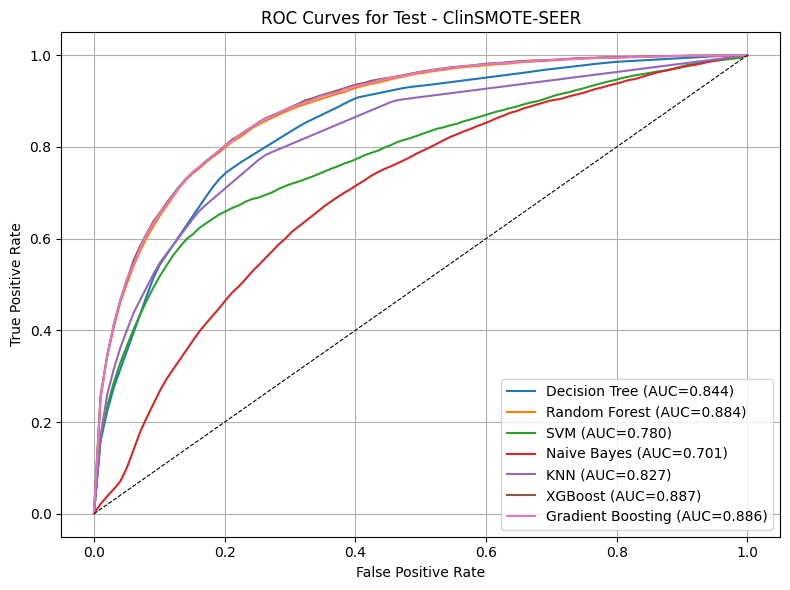

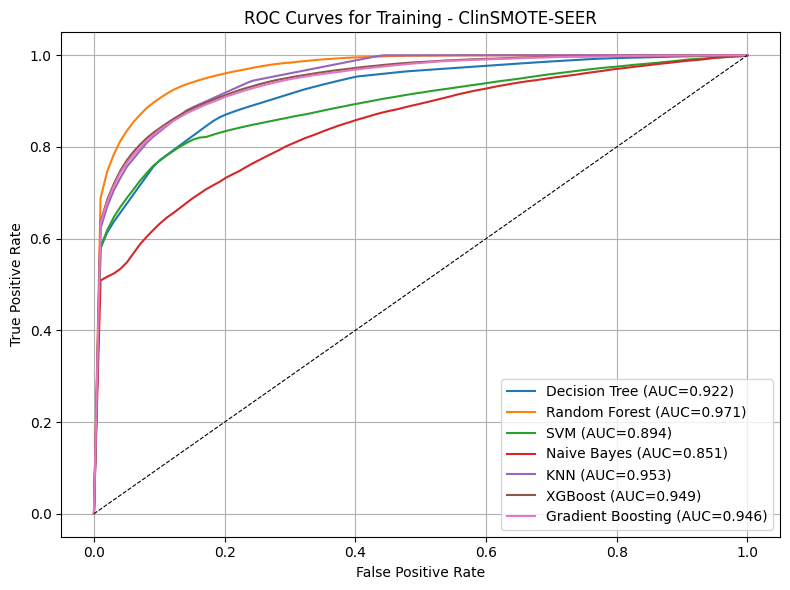


Tabela de Resultados - Teste:
  SMOTE Technique              Model  Accuracy       AUC  Precision  \
0  ClinSMOTE-SEER      Decision Tree  0.868452  0.843513   0.724936   
1  ClinSMOTE-SEER      Random Forest  0.886432  0.883888   0.728810   
2  ClinSMOTE-SEER                SVM  0.868751  0.779624   0.695199   
3  ClinSMOTE-SEER        Naive Bayes  0.824858  0.701336   0.250400   
4  ClinSMOTE-SEER                KNN  0.872455  0.826996   0.624530   
5  ClinSMOTE-SEER            XGBoost  0.886825  0.887220   0.704937   
6  ClinSMOTE-SEER  Gradient Boosting  0.886881  0.886114   0.696940   

   Recall rate  F1-score  
0     0.187075  0.294828  
1     0.369844  0.490617  
2     0.201365  0.312094  
3     0.091703  0.134177  
4     0.345939  0.445200  
5     0.404122  0.513643  
6     0.416264  0.521166  

Tabela de Resultados - Treinamento:
  SMOTE Technique              Model  Accuracy       AUC  Precision  \
0  ClinSMOTE-SEER      Decision Tree  0.886163  0.922079   0.943268   
1  Cl

In [ ]:
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Dicionários para armazenar as curvas ROC para cada técnica e modelo, separando teste e treinamento
roc_curves_test = {smote_name: {} for smote_name in smote_techniques.keys()}
roc_curves_train = {smote_name: {} for smote_name in smote_techniques.keys()}

# Listas para armazenar os resultados das tabelas para teste e treinamento
results_table_test = []
results_table_train = []

# Iteração entre técnicas de balanceamento e modelos
for smote_name, smote in smote_techniques.items():
    for model_name, model in models.items():
        print(f"\nAplicando {smote_name} com {model_name}")
        mean_fpr = np.linspace(0, 1, 100)

        # Listas para armazenar as curvas e métricas em cada fold (Teste)
        tprs_test = []
        aucs_test = []
        accuracies_test = []
        precisions_test = []
        recalls_test = []
        f1_scores_test = []

        # Listas para armazenar as curvas e métricas em cada fold (Treinamento)
        tprs_train = []
        aucs_train = []
        accuracies_train = []
        precisions_train = []
        recalls_train = []
        f1_scores_train = []

        # Validação cruzada
        for train_index, test_index in kf.split(X, y['Binary Mets']):
            # Separando os dados
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y['Binary Mets'].iloc[train_index], y['Binary Mets'].iloc[test_index]

            # Corrigir os índices antes de passar ao SMOTE
            X_train = X_train.reset_index(drop=True)
            y_train = pd.Series(y_train.reset_index(drop=True).values.ravel(), name='Binary Mets')

            # Aplicar ClinSMOTE-SEER no conjunto de treinamento
            X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

            # Normalizar os dados
            scaler = StandardScaler()
            X_train_res_scaled = scaler.fit_transform(X_train_res)
            X_test_scaled = scaler.transform(X_test)

            # Treinar o modelo com os dados balanceados
            model.fit(X_train_res_scaled, y_train_res)

            # ------------------------------
            # Avaliação no conjunto de Teste
            # ------------------------------
            y_pred_test = model.predict(X_test_scaled)
            y_pred_proba_test = model.predict_proba(X_test_scaled)[:, 1]

            # Curva ROC para teste
            fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test)
            interp_tpr_test = np.interp(mean_fpr, fpr_test, tpr_test)
            interp_tpr_test[0] = 0.0
            tprs_test.append(interp_tpr_test)
            aucs_test.append(auc(fpr_test, tpr_test))

            # Métricas para teste
            accuracies_test.append(accuracy_score(y_test, y_pred_test))
            precisions_test.append(precision_score(y_test, y_pred_test))
            recalls_test.append(recall_score(y_test, y_pred_test))
            f1_scores_test.append(f1_score(y_test, y_pred_test))

            # ------------------------------
            # Avaliação no conjunto de Treinamento
            # ------------------------------
            y_pred_train = model.predict(X_train_res_scaled)
            y_pred_proba_train = model.predict_proba(X_train_res_scaled)[:, 1]

            # Curva ROC para treinamento
            fpr_train, tpr_train, _ = roc_curve(y_train_res, y_pred_proba_train)
            interp_tpr_train = np.interp(mean_fpr, fpr_train, tpr_train)
            interp_tpr_train[0] = 0.0
            tprs_train.append(interp_tpr_train)
            aucs_train.append(auc(fpr_train, tpr_train))

            # Métricas para treinamento
            accuracies_train.append(accuracy_score(y_train_res, y_pred_train))
            precisions_train.append(precision_score(y_train_res, y_pred_train))
            recalls_train.append(recall_score(y_train_res, y_pred_train))
            f1_scores_train.append(f1_score(y_train_res, y_pred_train))

        # Cálculo das métricas médias para Teste
        mean_accuracy_test = np.mean(accuracies_test)
        mean_precision_test = np.mean(precisions_test)
        mean_recall_test = np.mean(recalls_test)
        mean_f1_test = np.mean(f1_scores_test)
        mean_auc_test = np.mean(aucs_test)

        # Cálculo das métricas médias para Treinamento
        mean_accuracy_train = np.mean(accuracies_train)
        mean_precision_train = np.mean(precisions_train)
        mean_recall_train = np.mean(recalls_train)
        mean_f1_train = np.mean(f1_scores_train)
        mean_auc_train = np.mean(aucs_train)

        # Armazenar as curvas ROC médias
        roc_curves_test[smote_name][model_name] = (mean_fpr, np.mean(tprs_test, axis=0), mean_auc_test)
        roc_curves_train[smote_name][model_name] = (mean_fpr, np.mean(tprs_train, axis=0), mean_auc_train)

        # Adicionar resultados à tabela de Teste
        results_table_test.append({
            "SMOTE Technique": smote_name,
            "Model": model_name,
            "Accuracy": mean_accuracy_test,
            "AUC": mean_auc_test,
            "Precision": mean_precision_test,
            "Recall rate": mean_recall_test,
            "F1-score": mean_f1_test
        })

        # Adicionar resultados à tabela de Treinamento
        results_table_train.append({
            "SMOTE Technique": smote_name,
            "Model": model_name,
            "Accuracy": mean_accuracy_train,
            "AUC": mean_auc_train,
            "Precision": mean_precision_train,
            "Recall rate": mean_recall_train,
            "F1-score": mean_f1_train
        })

# ------------------------------
# Plotar as curvas ROC para o conjunto de Teste
# ------------------------------
num_techniques = len(roc_curves_test)
fig_test, axes_test = plt.subplots(num_techniques, 1, figsize=(8, 6*num_techniques))
if num_techniques == 1:
    axes_test = [axes_test]
for i, technique in enumerate(roc_curves_test.keys()):
    ax = axes_test[i]
    for model_name, (fpr, tpr, mean_auc) in roc_curves_test[technique].items():
        ax.plot(fpr, tpr, label=f"{model_name} (AUC={mean_auc:.3f})")
    ax.plot([0, 1], [0, 1], 'k--', lw=0.8)
    ax.set_title(f"ROC Curves for Test - {technique}")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc='lower right')
    ax.grid()
plt.tight_layout()
plt.show()

# ------------------------------
# Plotar as curvas ROC para o conjunto de Treinamento
# ------------------------------
num_techniques = len(roc_curves_train)
fig_train, axes_train = plt.subplots(num_techniques, 1, figsize=(8, 6*num_techniques))
if num_techniques == 1:
    axes_train = [axes_train]
for i, technique in enumerate(roc_curves_train.keys()):
    ax = axes_train[i]
    for model_name, (fpr, tpr, mean_auc) in roc_curves_train[technique].items():
        ax.plot(fpr, tpr, label=f"{model_name} (AUC={mean_auc:.3f})")
    ax.plot([0, 1], [0, 1], 'k--', lw=0.8)
    ax.set_title(f"ROC Curves for Training - {technique}")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc='lower right')
    ax.grid()
plt.tight_layout()
plt.show()

# ------------------------------
# Criar e salvar as tabelas de resultados
# ------------------------------
results_df_test = pd.DataFrame(results_table_test)
results_df_train = pd.DataFrame(results_table_train)

results_df_test.to_csv("comparison_table_test.csv", index=False)
results_df_train.to_csv("comparison_table_train.csv", index=False)

print("\nTabela de Resultados - Teste:")
print(results_df_test)
print("\nTabela de Resultados - Treinamento:")
print(results_df_train)
